<a href="https://colab.research.google.com/github/ExtensionIntention/genie/blob/master/PCP_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Publication Count Prediction Classifier

### Authenticate

In [0]:
from google.colab import auth
auth.authenticate_user()

## Imports

In [0]:
import requests
import json

In [0]:
# Imports
import os
import math
import glob
from time import time
from datetime import datetime
import pickle

# Math
import numpy as np
import pandas as pd
from numpy import interp
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import seaborn as sns

import warnings
# we do not need future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import xgboost
from xgboost import XGBClassifier

import sklearn
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc, roc_auc_score, roc_curve, f1_score

# Model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight 
from sklearn.utils.class_weight import compute_class_weight

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.style

from matplotlib.colors import ListedColormap

dark2_colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
dark2_cmap = ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (10, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 12
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()
mpl.style.use('seaborn-dark-palette')

import seaborn as sns #If you don't have seaborn, use - conda install seaborn
current_palette = sns.color_palette()

## Loading and Forming
We have pre-processed data which relates gene-disease relationships to articles which pertain to them (the CTD gene-diesease relationship table). The first step is to pull this with BigQuery and combine it with the associated PubMed article metadata. To this end, we also pull all required PubMed metadata using BigQuery to construct a local article dictionary for feature processing convenience.

In [0]:
# Append publication count statistics
def addPubCount(df):
    df['PubCount'] = ''
    df['CountMag'] = ''

    startTime = time()
    # iterate throw rows and count
    # also throw in order of magnitude
    for i, row in df.iterrows():
        cur_ids = row.PubMedIDs.split('|')
        df.at[i, 'PubCount'] = len(cur_ids)
        if len(cur_ids) <= 10:
            cmag = 0
        elif len(cur_ids) <= 100:
            cmag = 1
        else:
            cmag = 2
        df.at[i, 'CountMag'] = cmag

    print('Add pub count time: %fs' % (time()-startTime))

    return df

In [0]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'harvard-599-trendsetters'

startTime = time()

# call BigQuery
df = pd.io.gbq.read_gbq(f'''
  SELECT *
  FROM `harvard-599-trendsetters.ctd.gene_disease_relationships` 
  WHERE LENGTH(PubMedIDs) > 10
  LIMIT 100000
''', project_id=project_id)

print('Total time: %fs' % (time()-startTime))
print(' Results: %d' % len(df))
dis_mesh = np.unique(df['DiseaseID'])
gene_ids = np.unique(df['GeneID'])
df['InferenceScore'] = pd.to_numeric(df['InferenceScore'])
print(' Unique diseases: %d' % len(dis_mesh))
print(' Unique genes: %d' % len(gene_ids))
addPubCount(df)
df.head()

Total time: 13.863927s
 Results: 100000
 Unique diseases: 1490
 Unique genes: 5156
Add pub count time: 12.412300s


,GeneSymbol,GeneID,DiseaseName,DiseaseID,DirectEvidence,InferenceChemicalName,InferenceScore,OmimIDs,PubMedIDs,PubCount,CountMag
0,A1BG,1,Blood Coagulation Disorders,MESH:D001778,None,Tretinoin,36.89,None,15087033|16197459|16206674,3,0
1,A1BG,1,"Leukemia, Myeloid, Acute",MESH:D015470,None,Tretinoin,4.21,None,16294345|17596541|19850784|22541086,4,0
2,A1BG-AS1,503538,Hyperinsulinism,MESH:D006946,None,Valproic Acid,3.13,None,19184102|29229235,2,0
3,A1CF,29974,Hyperuricemia,MESH:D033461,None,Uric Acid,17.77,None,19605544|20123605|20506124|22003309,4,0
4,A2M,2,Autism Spectrum Disorder,MESH:D000067877,None,Valproic Acid,35.55,None,20734317|21195144|23613074|29309796|29510222|3...,6,0


### Sanity Stats

In [0]:
dfc = df.copy()
dfc['GeneTotal'] = dfc.groupby(['GeneSymbol'])['PubCount'].transform('sum')
dfc = dfc.drop_duplicates(subset=['GeneSymbol'])

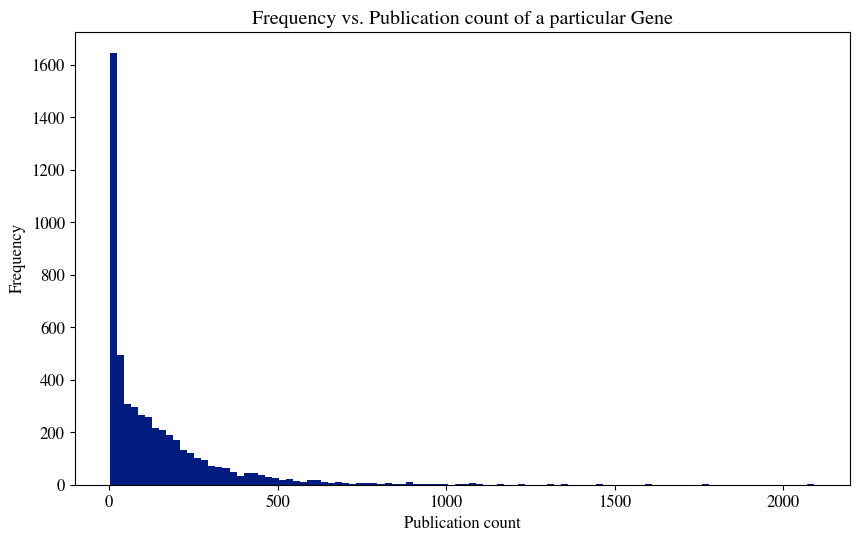

In [0]:
plt.hist(dfc['GeneTotal'].values, 100)
plt.title('Frequency vs. Publication count of a particular Gene')
plt.xlabel('Publication count')
plt.ylabel('Frequency')
plt.show()

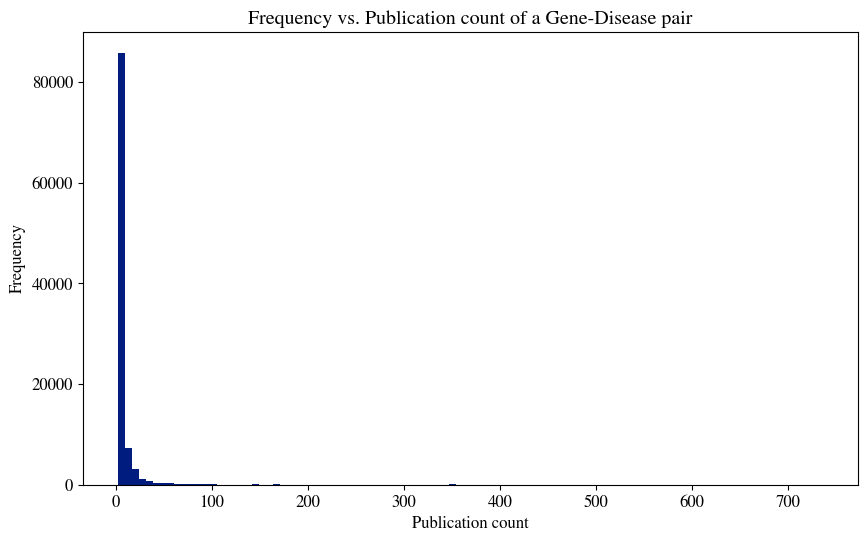

In [0]:
plt.hist(df['PubCount'].values, 100)
plt.title('Frequency vs. Publication count of a Gene-Disease pair')
plt.xlabel('Publication count')
plt.ylabel('Frequency')
plt.show()

# Forming functions

In [0]:
df.head()

,GeneSymbol,GeneID,DiseaseName,DiseaseID,DirectEvidence,InferenceChemicalName,InferenceScore,OmimIDs,PubMedIDs,PubCount,CountMag
0,A1BG,1,Blood Coagulation Disorders,MESH:D001778,None,Tretinoin,36.89,None,15087033|16197459|16206674,3,0
1,A1BG,1,"Leukemia, Myeloid, Acute",MESH:D015470,None,Tretinoin,4.21,None,16294345|17596541|19850784|22541086,4,0
2,A1BG-AS1,503538,Hyperinsulinism,MESH:D006946,None,Valproic Acid,3.13,None,19184102|29229235,2,0
3,A1CF,29974,Hyperuricemia,MESH:D033461,None,Uric Acid,17.77,None,19605544|20123605|20506124|22003309,4,0
4,A2M,2,Autism Spectrum Disorder,MESH:D000067877,None,Valproic Acid,35.55,None,20734317|21195144|23613074|29309796|29510222|3...,6,0


In [0]:
# steps through dataframe and collects a set of all PubMedIDs
def getPubMedList(df):
    idSet = set()
    startTime = time()
    for i, row in df.iterrows():
        cur_ids = row.PubMedIDs.split('|')
        cur_ints = [int(x) for x in cur_ids]
        idSet.update(cur_ints)

    print(' Total unique PubMed IDs: %d' % len(idSet))
    print('Count ID time: %fs' % (time()-startTime))

    return idSet

In [0]:
# pulls all PubMed article metadata in the given set
def getPubMedMetaDF(idSet):
    project_id = 'harvard-599-trendsetters'
    tStart = time()
    print('Forming %d PMIDs' % len(idSet))

    idx = 0
    load_str = str(idSet)[1:-2]
    startTime = time()
    df_out = pd.io.gbq.read_gbq(f'''
    SELECT *
    FROM `harvard-599-trendsetters.pubmed.baseline_02032020`
    WHERE pmid in (%s)
    LIMIT %d
    ''' % (load_str, len(idSet)), project_id=project_id)

    print('Total time: %fs' % (time()-startTime))
    print(df_out.head())
    print(df_out.shape)
    
    return df_out

In [0]:
# hard coded values of PubMed metadata tags
cnames = ['chemicals', 'abstract', 'mesh_list', 'article_title',
       'iso_abbreviation', 'authors', 'pub_model', 'language',
       'date_completed', 'title', 'pmid']

# class container for article metadata
class PubMedArticle:

    def __init__(self, meta_s):
        # loop through tags and save
        for name in cnames:
            if not name == 'date_completed':
                setattr(self, name, meta_s[name])
            else:
                # for dates save as datetime
                try:
                    setattr(self, name, datetime.strptime(meta_s[name], '%Y-%m-%d'))
                except:
                    setattr(self, name, None) # save None when no valid date

    # diagnostic print
    def dump(self):
        for name in cnames:
            print('%s: %s' % (name, str(getattr(self, name))))

# create dictionary with PMID as the key and PubMedArticle class as value
def formPubMedDict(df_meta, verbose=False):
    meta_dict = dict()
    tStart = time()
    for idx, row in df_meta.iterrows():
        if verbose and idx % 1000 == 0:
            print(idx)
        # feed row series to constructor
        pma = PubMedArticle(row)
        meta_dict[pma.pmid] = pma
    print('Elapsed: %fs' % (time()-tStart))
    return meta_dict   

In [0]:
# get all unique PMIDs in df
pIds = getPubMedList(df)

 Total unique PubMed IDs: 43631
Count ID time: 10.805917s


In [0]:
# pull PubMed article metadata from BigQuery and parse to dataframe
df_meta = getPubMedMetaDF(pIds)

Forming 43631 PMIDs
Total time: 38.327847s
  chemicals  ...      pmid
0        []  ...  30816183
1        []  ...  30783172
2        []  ...  30809271
3        []  ...  30807803
4        []  ...  30825513

[5 rows x 11 columns]
(43603, 11)


In [0]:
# form the randomly assorted metadata into dictionary with PMID as key and metadata container class as value
meta_dict = formPubMedDict(df_meta, verbose=True)

Elapsed: 12.160857s


In [0]:
# returns boolean of if the target date is in the test range, returns false on invalid date
def date_in_range(target_date, test_range):
    if target_date:
        return target_date >= test_range[0] and target_date <= test_range[1]
    return False

In [0]:
# plot test histogram
def plot_hist(data, append_str=''):
    plt.hist(data, 100)
    plt.title('Frequency vs. Count %s ' % append_str)
    plt.xlabel('Count')
    plt.ylabel('Frequency')
    plt.show()

In [0]:
# split dataframe into features and labels based on date intervals
# TODO: currently date ranges are hard coded!
def feature_label_id_split(df, meta_dict, verbose=False):
    df_c = df.copy()
    df_c['FeatureIDs'] = ''
    df_c['LabelIDs'] = ''
    df_c['FeatureIDsCount'] = ''
    df_c['LabelIDsCount'] = ''
    df_c['Fmag'] = ''
    df_c['Lmag'] = ''

    labelRange = [datetime(2015, 1, 1), datetime(2020, 1, 1)]
    featureRange = [datetime(1, 1, 1,), datetime(2005, 1, 1)]

    startTime = time()
    for i, row in df_c.iterrows():
        if verbose and i % 1000 == 0:
            print(i)
        cur_ids = row.PubMedIDs.split('|')
        labelIds = []
        featureIds = []
        for id in cur_ids:
            cur_id = int(id)

            if cur_id in meta_dict:
                cur_a = meta_dict[cur_id]
                if date_in_range(cur_a.date_completed, labelRange):
                    labelIds.append(cur_id)
                elif date_in_range(cur_a.date_completed, featureRange):
                    featureIds.append(cur_id)

        df_c.at[i, 'FeatureIDs'] = featureIds
        df_c.at[i, 'LabelIDs'] = labelIds
        df_c.at[i, 'FeatureIDsCount'] = len(featureIds)
        df_c.at[i, 'LabelIDsCount'] = len(labelIds)
        # get log10 magnitude of label publications
        df_c.at[i, 'Fmag'] = 0 if len(featureIds) == 0 else int(np.floor(np.log10(len(featureIds))))
        df_c.at[i, 'Lmag'] = 0 if len(labelIds) == 0 else int(np.floor(np.log10(len(labelIds))))

    if verbose:
        plot_hist(df_c['FeatureIDsCount'].values)
        plot_hist(df_c['LabelIDsCount'].values)       

    print('Feature - label split time: %fs' % (time()-startTime))
    return df_c

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


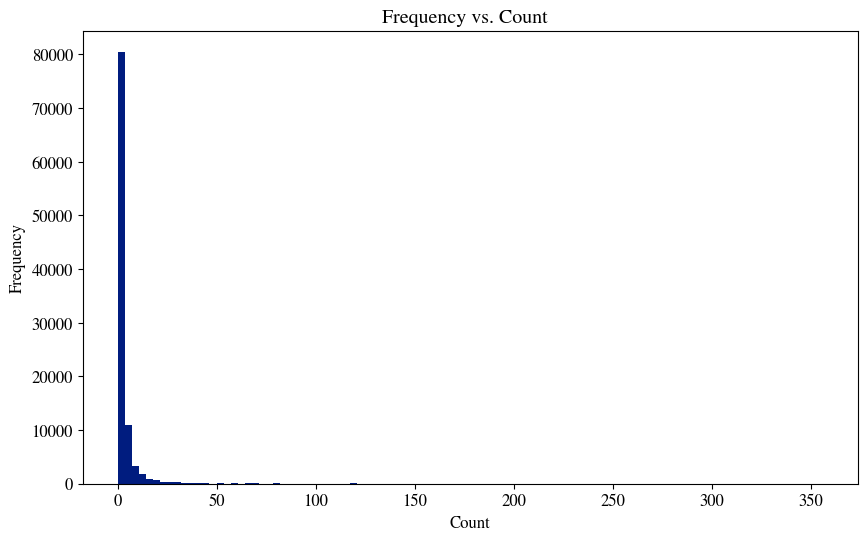

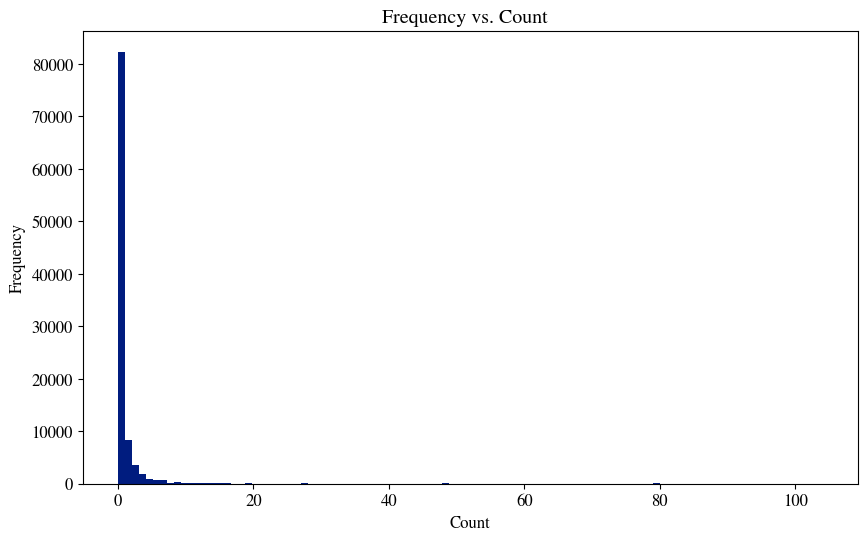

Feature - label split time: 21.179897s


In [0]:
df_c = feature_label_id_split(df, meta_dict, verbose=True)

In [0]:
# only accept rows where we have non-zero values in both the feature and label date range
valids = (df_c['FeatureIDsCount'] > 0).values & (df_c['LabelIDsCount'] > 0).values
df_v = df_c.loc[valids]
df_v.shape

(13737, 17)

In [0]:
df_v.head()

,GeneSymbol,GeneID,DiseaseName,DiseaseID,DirectEvidence,InferenceChemicalName,InferenceScore,OmimIDs,PubMedIDs,PubCount,CountMag,FeatureIDs,LabelIDs,FeatureIDsCount,LabelIDsCount,Fmag,Lmag
5,A2M,2,Gastritis,MESH:D005756,None,Indomethacin,19.49,None,15046732|16080005|2266080|29523851,4,0,"[15046732, 2266080]",[29523851],2,1,0,0
9,A3GALT2,127550,Craniofacial Abnormalities,MESH:D019465,None,Tetrachlorodibenzodioxin,9.18,None,10048152|15322242|19279074|20055451|22403156|2...,6,0,"[10048152, 15322242]",[26320568],2,1,0,0
19,AACS,65985,Weight Gain,MESH:D015430,None,Nicotine,81.17,None,29155039|8956374,2,0,[8956374],[29155039],1,1,0,0
22,AADAC,13,"Arthritis, Juvenile",MESH:D001171,None,Methotrexate,2.43,None,12682624|16639486|17631750|19565504|20954192|2...,9,0,"[12682624, 2388211]",[27166432],2,1,0,0
25,AADAT,51166,Kidney Diseases,MESH:D007674,None,Carbon Tetrachloride,105.15,None,25899501|2905310|29522708,3,0,[2905310],"[25899501, 29522708]",1,2,0,0


In [0]:
df_features = df_v[['GeneID', 'DiseaseID']].copy()

In [0]:
df_features.head()

,GeneID,DiseaseID
5,2,MESH:D005756
9,127550,MESH:D019465
19,65985,MESH:D015430
22,13,MESH:D001171
25,51166,MESH:D007674


In [0]:
df_features['InferenceScore'] = df_v['InferenceScore']

In [0]:
labels = df_v['Lmag'].astype(int)
print(np.sum(labels))

830


In [0]:
# encoder
def encode_data(df, standardize=True, drop_first=False, pair=False, drops=[]):
    '''
    df - input dataframe
    standardize - mean and divide by standard deviation
    drop_first - drop the first variable in one-hot encoding
    '''

    tStart = time()

    df_out = df.copy()
    
    # drop columns if specified
    if len(drops) > 0:
        df_out = df_out.drop(columns=drops, axis=1)

    categorical_names = []
    numeric_names = []

    if standardize:
        for col in df_out.columns:
            # GeneID is a categorical variable for our purposes and is skipped
            if col == 'phase':
                categorical_names.append('GeneID')
                continue
            if is_numeric_dtype(df_out[col]):
                numeric_names.append(col)
                df_out[col] = StandardScaler().fit_transform(df_out[[col]].values)
            else:
                categorical_names.append(col)
    
    # append paired covariates (very memory intensive)
    if pair:
        for name1 in numeric_names:
            for name2 in numeric_names:
                if name1 == name2:
                    continue
                df_out['%s_%s' % (name1, name2)] = df_out[name1] * df_out[name2]

    # transform categorical covariates to dummies (one-hot)
    df_out = pd.get_dummies(df_out, columns=categorical_names, drop_first=drop_first)
    
    print('Encode  time: %fs' % (time()-tStart))
    
    return df_out

In [0]:
df_e = encode_data(df_features)

Encode  time: 0.512872s


In [0]:
df_e.head()

,InferenceScore,GeneID_1,GeneID_100,GeneID_1000,GeneID_10000,GeneID_100001129,GeneID_100001603,GeneID_100002545,GeneID_100002938,GeneID_100003090,GeneID_100003419,GeneID_100004607,GeneID_100004990,GeneID_100005587,GeneID_100005593,GeneID_100005752,GeneID_100006005,GeneID_100006238,GeneID_100007164,GeneID_100007763,GeneID_100020791,GeneID_100037315,GeneID_100041585,GeneID_100042493,GeneID_100043686,GeneID_10005,GeneID_10006,GeneID_1001,GeneID_100101640,GeneID_100101938,GeneID_100126106,GeneID_100127983,GeneID_100128569,GeneID_100129271,GeneID_100129792,GeneID_100130301,GeneID_100130418,GeneID_100131244,GeneID_100131755,GeneID_100132111,...,DiseaseID_MESH:D020246,DiseaseID_MESH:D020258,DiseaseID_MESH:D020261,DiseaseID_MESH:D020262,DiseaseID_MESH:D020426,DiseaseID_MESH:D020521,DiseaseID_MESH:D020734,DiseaseID_MESH:D020751,DiseaseID_MESH:D020964,DiseaseID_MESH:D022124,DiseaseID_MESH:D029424,DiseaseID_MESH:D034381,DiseaseID_MESH:D048629,DiseaseID_MESH:D049188,DiseaseID_MESH:D050171,DiseaseID_MESH:D050197,DiseaseID_MESH:D051437,DiseaseID_MESH:D052016,DiseaseID_MESH:D052556,DiseaseID_MESH:D053099,DiseaseID_MESH:D053627,DiseaseID_MESH:D054198,DiseaseID_MESH:D054556,DiseaseID_MESH:D055370,DiseaseID_MESH:D055371,DiseaseID_MESH:D055752,DiseaseID_MESH:D055985,DiseaseID_MESH:D056486,DiseaseID_MESH:D057049,DiseaseID_MESH:D058065,DiseaseID_MESH:D058186,DiseaseID_MESH:D058625,DiseaseID_MESH:D062025,DiseaseID_MESH:D063647,DiseaseID_MESH:D064420,DiseaseID_MESH:D065626,DiseaseID_MESH:D065630,DiseaseID_MESH:D065666,DiseaseID_MESH:D066126,DiseaseID_OMIM:613290
5,-0.489283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,-0.626443,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19,0.331282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22,-0.716242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0.650302,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# avoid NaNs
for i, row in df_e.iterrows():    
    if np.isnan(df_e.at[i, 'InferenceScore']):        
        print(df_e.at[i, 'InferenceScore'])
        df_e.at[i, 'InferenceScore'] = 0
        print(df_e.at[i, 'InferenceScore'])
        

nan
0.0


In [0]:
np.any(np.isnan(df_e['InferenceScore'].values))

False

In [0]:
# test features with random forest
# reference: section 9

def test_random_forest(processed_features, labels, n_estimators=200, test_size=0.2, max_depth=None, random_state=0, verbose=True):
    X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=test_size, random_state=random_state)

    tStart = time()
    classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, max_depth=max_depth)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    if verbose:
        print('Fit time: %fs' % (time()-tStart))
        print('Accuracy of on training: %f' % classifier.score(X_train, y_train))
        print('Accuracy of validation: %f' % classifier.score(X_test, y_test))
        print(confusion_matrix(y_test,predictions))
        print(classification_report(y_test,predictions))
        print(accuracy_score(y_test, predictions))
    return classifier, X_train, X_test, y_train, y_test



# Classifier summary

In [0]:
# classifier summary
classifier, X_train, X_test, y_train, y_test = test_random_forest(df_e, labels)

Fit time: 52.115889s
Accuracy of on training: 0.995814
Accuracy of validation: 0.950509
[[2581    8    0]
 [ 128   30    0]
 [   0    0    1]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2589
           1       0.79      0.19      0.31       158
           2       1.00      1.00      1.00         1

    accuracy                           0.95      2748
   macro avg       0.91      0.73      0.76      2748
weighted avg       0.94      0.95      0.94      2748

0.950509461426492


In [0]:
meta_dict[15046732].authors

['Larauche, Muriel',
 'Anton, Pauline M',
 'Peiro, Géraldine',
 'Eutamène, Hélène',
 'Buéno, Lionel',
 'Fioramonti, Jean']